<a href="https://colab.research.google.com/github/reynoso811/Image-Classification-Pneumonia-X-rays-/blob/main/Phase_04_MLP_CNN_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pneumonia detection on chest X-rays

## Importing libraries

In [ ]:
import numpy as np
import pandas as pd 
import random as rn

# tensorflow
import tensorflow.random as tfr
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Lambda, Input
from tensorflow.keras.layers import Conv2D, MaxPool2D, MaxPooling2D, BatchNormalization
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Plotting
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import seaborn as sns

from skimage import color, exposure
from sklearn.metrics import classification_report

import os
import cv2

# Setting the same seed for repeatability

seed = 0

np.random.seed(seed) 
rn.seed(seed)
tfr.set_seed(seed)

# Display graphs in a Jupyter
%matplotlib inline

print("Imported")

Imported


## Read the data

In [ ]:
# Google Drive connection

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Create a path to the root folder and path to specific folders

data_path = '/content/drive/MyDrive/Phase_04_project/chest_xray/chest_xray/'
data_path

train_path = data_path + 'train/'
test_path = data_path + 'test/'
val_path = data_path + 'val/'

In [ ]:
# Optimal image size for modeling

img_size = 200

In [ ]:
# Custom function to read data from folders
# Returns numpy array [img, label]

def read_data(data_paths):
    for data_path in data_paths:
        labels = ['PNEUMONIA', 'NORMAL']
        images = []
        y = []
        for label in labels:
            curr_path = data_path + label
            for img in os.listdir(curr_path):
                if ('DS' not in img):
                    image_path = os.path.join(curr_path, img)
                    image =  cv2.resize(cv2.imread(image_path), (img_size, img_size))
                    if image is not None:
                        images.append([image, label])
                
    images = np.asarray(images)
    return images

In [ ]:
%%time
train = read_data([train_path])
test = read_data([val_path, test_path])

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


CPU times: user 1min 39s, sys: 6.12 s, total: 1min 45s
Wall time: 25min 5s


In [ ]:
# Shuffle the data

for i in range(10):
    np.random.shuffle(train)
    np.random.shuffle(test)

In [ ]:
# Create data frame for visualization

train_df = pd.DataFrame(train, columns=['image', 'label'])
test_df = pd.DataFrame(test, columns = ['image', 'label'])

In [ ]:
train_df.head()

,image,label
0,"[[[59, 59, 59], [64, 64, 64], [66, 66, 66], [6...",PNEUMONIA
1,"[[[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], ...",PNEUMONIA
2,"[[[34, 34, 34], [42, 42, 42], [62, 62, 62], [1...",NORMAL
3,"[[[186, 186, 186], [167, 167, 167], [131, 131,...",PNEUMONIA
4,"[[[210, 210, 210], [212, 212, 212], [207, 207,...",PNEUMONIA


In [ ]:
train_df['label'].head()

0    PNEUMONIA
1    PNEUMONIA
2       NORMAL
3    PNEUMONIA
4    PNEUMONIA
Name: label, dtype: object

In [ ]:
train_df['image'][10]

array([[[  0,   0,   0],
        [  6,   6,   6],
        [ 10,  10,  10],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  5,   5,   5],
        [ 10,  10,  10],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  5,   5,   5],
        [ 10,  10,  10],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[  1,   1,   1],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [250, 250, 250],
        [  4,   4,   4],
        [  1,   1,   1]],

       [[  1,   1,   1],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  1,   1,   1],
        [  1,   1,   1],
        [  1,   1,   1]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]]

# Exploratory Data Analysis (EDA)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


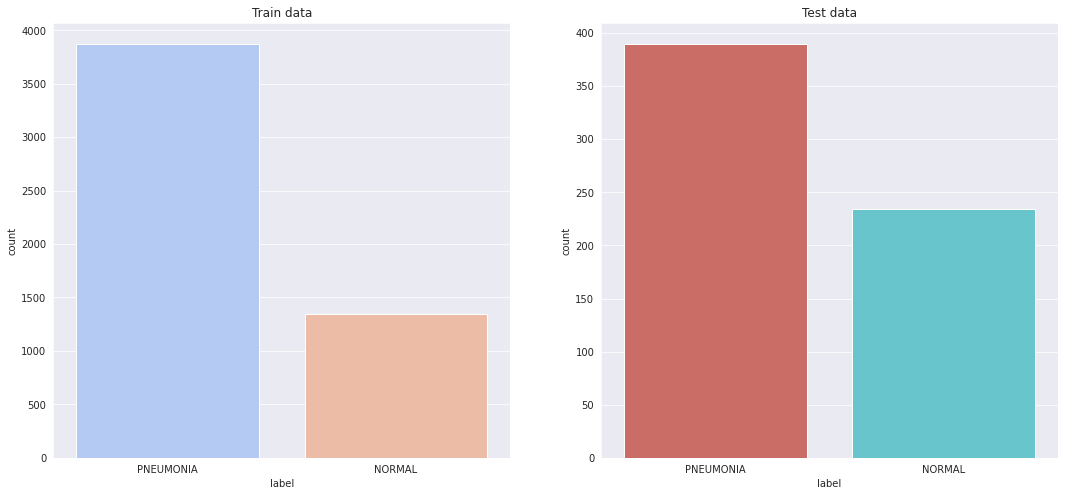

In [ ]:
plt.figure(figsize=(18, 8))
sns.set_style("darkgrid")

plt.subplot(1,2,1)
sns.countplot(train_df['label'], palette = 'coolwarm')
plt.title('Train data')

plt.subplot(1,2,2)
sns.countplot(test_df['label'], palette = "hls")
plt.title('Test data')

plt.show()

In [ ]:
train_df.shape

(5216, 2)

In [ ]:
test_df.shape

(624, 2)

Disproportions in the data distribuition. Try to normolize later.

# Visualize the images

CPU times: user 1.45 s, sys: 203 ms, total: 1.65 s
Wall time: 1.53 s


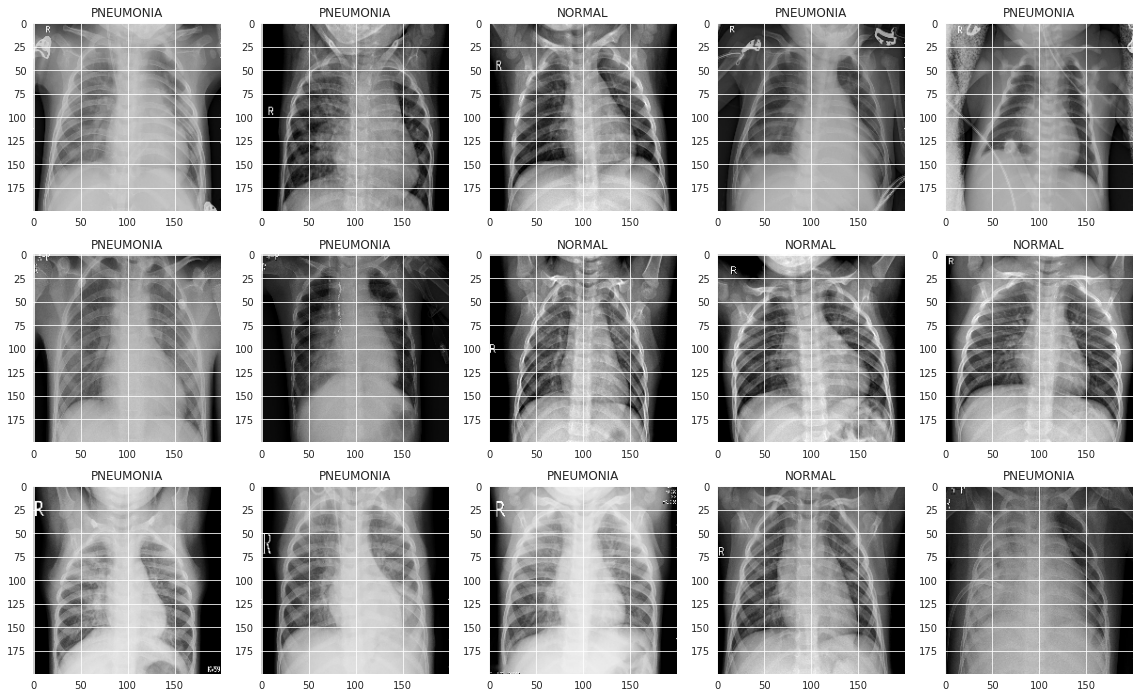

In [ ]:
%%time

def Show_example_image():
    fig = plt.figure(figsize = (16, 16))
    for idx in range(15):
        plt.subplot(5, 5, idx+1)
        plt.imshow(train_df.iloc[idx]['image'])
        plt.title("{}".format(train_df.iloc[idx]['label']))
        
    plt.tight_layout()
    
Show_example_image()

# Data preprocessing

In [ ]:
def lung_condition(label):
    if label == 'NORMAL':
        return 0
    else:
        return 1

In [ ]:
# Function for dividing data into arrays X and y

def splitdata(data):
    X = []
    y = []
    for i, (val, label) in enumerate(data):
        X.append(val)
        y.append(lung_condition(label))
    return np.array(X), np.array(y)

In [ ]:
# Split the data

np.random.shuffle(train)
np.random.shuffle(test)
X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)


In [ ]:
# Grayscale conversion, normalization, and table reshaping function for MLP

def preprocesing_to_mlp(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size * img_size).astype('float32')
    
    # Data Normalization [0, 1]
    data1 /= 255
    
    return data1

In [ ]:

X_train = preprocesing_to_mlp(X_train)
X_test = preprocesing_to_mlp(X_test)


In [ ]:
num_pixels = X_train.shape[1] 

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

num_classes = y_train.shape[1]

In [ ]:
# Function for drawing learning curve history on learning neural network

def draw_learning_curve(history, keys=['accuracy', 'loss']):
    plt.figure(figsize=(20,8))
    for i, key in enumerate(keys):
        plt.subplot(1, 2, i + 1)
        sns.lineplot(x = history.epoch, y = history.history[key])
        sns.lineplot(x = history.epoch, y = history.history['val_' + key])
        plt.title('Learning Curve')
        plt.ylabel(key.title())
        plt.xlabel('Epoch')
#         plt.ylim(ylim)
        plt.legend(['train', 'test'], loc='best')
    plt.show()

# Modeling




## MLP (Multilayer perceptron)

### Notes on MLP, how it works and why its bad...

## #1
##Definitions:
* The **batch size** is a hyperparameter of gradient descent that controls the number of training samples to work through before the model’s internal parameters are updated.
* batch size is a number of samples processed before the model is updated.

* The number of **epochs** is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.
*epochs is the number of complete passes through the training dataset.

You can run the algorithm for as long as you like and even stop it using other criteria besides a fixed number of epochs, such as a change (or lack of change) in model error over time.

# Activations 

- relu: 
- softmax:

## Units (

In [ ]:
# 1st model 
# 
def get_mlp():
    
    return Sequential([
        #input layer is automatic generation by keras
        
        #hidden layer
        Dense(1024, input_dim = num_pixels, activation='relu'),
        
        #output layer
        Dense(num_classes, activation='softmax')
    ])

In [ ]:
model = get_mlp()
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              40961024  
                                                                 
 dense_1 (Dense)             (None, 2)                 2050      
                                                                 
Total params: 40,963,074
Trainable params: 40,963,074
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define callbacks parameters

callbacks1 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('../working/model.best1.hdf5',monitor='loss', save_best_only=True) # saving the best model
]

In [ ]:
# Fitting model 1

%%time

learning_history = model.fit(X_train, y_train,
          batch_size = 64, epochs = 40, verbose = 2,
          callbacks = callbacks1,
          validation_data=(X_test, y_test));

Epoch 1/40
82/82 - 27s - loss: 0.3925 - accuracy: 0.8202 - val_loss: 0.4624 - val_accuracy: 0.7628 - lr: 0.0010 - 27s/epoch - 335ms/step
Epoch 2/40
82/82 - 26s - loss: 0.1970 - accuracy: 0.9250 - val_loss: 0.5047 - val_accuracy: 0.7676 - lr: 0.0010 - 26s/epoch - 319ms/step
Epoch 3/40
82/82 - 26s - loss: 0.1468 - accuracy: 0.9467 - val_loss: 0.4382 - val_accuracy: 0.8029 - lr: 0.0010 - 26s/epoch - 318ms/step
Epoch 4/40
82/82 - 26s - loss: 0.1348 - accuracy: 0.9488 - val_loss: 0.6110 - val_accuracy: 0.7660 - lr: 0.0010 - 26s/epoch - 319ms/step
Epoch 5/40
82/82 - 26s - loss: 0.1202 - accuracy: 0.9561 - val_loss: 0.6202 - val_accuracy: 0.7708 - lr: 0.0010 - 26s/epoch - 314ms/step
Epoch 6/40
82/82 - 25s - loss: 0.1276 - accuracy: 0.9519 - val_loss: 0.9618 - val_accuracy: 0.7179 - lr: 0.0010 - 25s/epoch - 301ms/step
Epoch 7/40
82/82 - 24s - loss: 0.1244 - accuracy: 0.9532 - val_loss: 1.2358 - val_accuracy: 0.7051 - lr: 0.0010 - 24s/epoch - 296ms/step
Epoch 8/40
82/82 - 26s - loss: 0.1131 - a

## MLP Evaluation

In [ ]:
# model 1 evaluation

score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 101.3615369796753%
Test accuracy: 74.5192289352417%
MLP Error: 25.48%


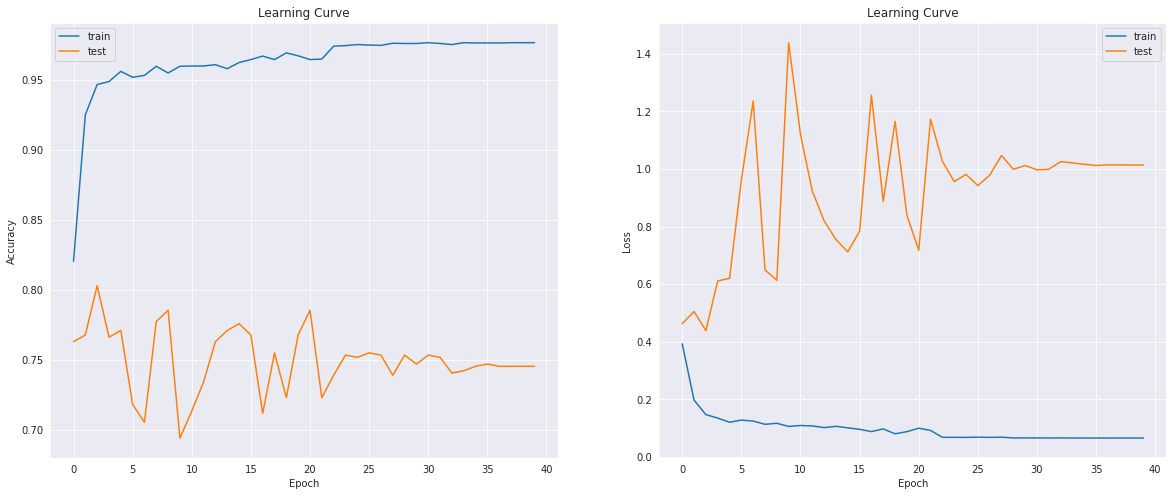

In [ ]:
draw_learning_curve(learning_history)

# MLP Model Summary:

* Best accuracy this MLP model acheived was ~75%

* The model is overfitting, quite a bit. We can see around Epoch 20 on the  Accuracy graph that the model doesn't not improve.

* This model could be improved/tuned by using differnet activation functions, trying different optimizers, including early stopping and different degrees of dropouts.

Visualizing Keras models

In [31]:
!pip3 install keras-visualizer
from keras import models  
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Activation  
from keras_visualizer import visualizer 

In [29]:
from keras.utils.vis_utils import plot_model


In [ ]:
test2 = plot_model(model, to_file='/content/drive/MyDrive/Phase_04_project/model.png')

In [ ]:
 test1 = visualizer(model, format='png', view=True)

In [ ]:
# Saving model 1

save1 = model.save('/content/drive/MyDrive/Phase_04_project/model_sequential.best1.hdf5')

# #2

In [ ]:
# model 2

callbacks2 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('../working/model.best2.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [ ]:
def get_mlpv2():
    
    return Sequential([
        Dense(1024, input_dim=num_pixels, activation='relu'),
        Dropout(0.4),
        Dense(512, activation='relu'),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

In [ ]:
# Fitting model 2

%%time

learning_history_2 = model.fit(X_train, y_train,
          batch_size = 64, epochs = 100, verbose = 1,
          callbacks = callbacks2,
          validation_data=(X_test, y_test));

Epoch 1/100
82/82 [==============================] - 25s 301ms/step - loss: 0.5898 - accuracy: 0.7358 - val_loss: 0.6858 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 25s 308ms/step - loss: 0.5692 - accuracy: 0.7429 - val_loss: 0.6842 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 24s 296ms/step - loss: 0.5679 - accuracy: 0.7429 - val_loss: 0.7068 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 24s 295ms/step - loss: 0.5658 - accuracy: 0.7429 - val_loss: 0.6792 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 24s 294ms/step - loss: 0.5637 - accuracy: 0.7429 - val_loss: 0.6819 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 24s 295ms/step - loss: 0.5600 - accuracy: 0.7429 - val_loss: 0.6872 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/100
82/82 [==============================] - 24s 2

In [ ]:
# Model 2 evaluation

score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 64.85501527786255%
Test accuracy: 75.96153616905212%
MLP Error: 24.04%


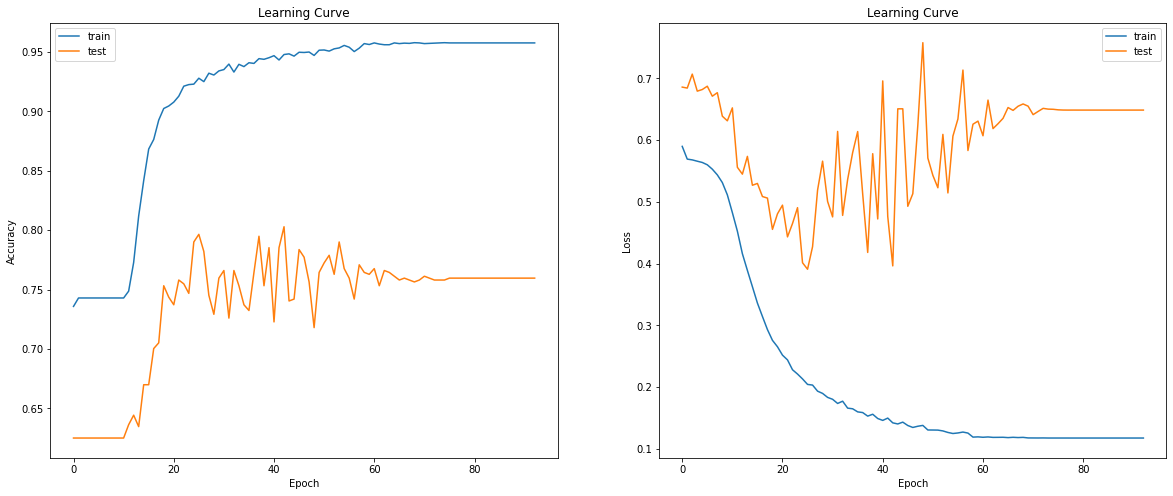

In [ ]:
draw_learning_curve(learning_history_2)

# MLP Model 2 Summary:

* Best accuracy this MLP model acheived was ~76%

* Increased layers from 2 to 4

* Same activation function (try diff next)

* The Dropout layers help prevent overfitting

* ReLU is one of the most commonly used activation functions around right now it's especially useful in computer vision problems like image classification



In [ ]:
# Saving model 2

model = model.save('model_sequential.best2.hdf5')

Visualizing Keras models

In [ ]:
test3 = plot_model(model, to_file='/content/drive/MyDrive/Phase_04_project/model_2.png')

In [ ]:
 test3 = visualizer(model, format='png', view=True)

# CNN (Convolutional Neural Network)

## Data pre-processing for CNN

In [ ]:
# Reshape data again

X_train, y_train = splitdata(train)
X_test, y_test = splitdata(test)

In [ ]:
# Grayscale conversion, normalization, and table reshaping function for CNN

def preprocesing_to_cnn(data):
    data1 = color.rgb2gray(data).reshape(-1, img_size, img_size, 1).astype('float32')
    data1 /= 255
    return data1

In [ ]:
X_train = preprocesing_to_cnn(X_train)
X_test = preprocesing_to_cnn(X_test)

# one-hot encoding for target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [ ]:
num_classes = y_train.shape[1]

In [ ]:
input_shape = (img_size, img_size, 1)

In [ ]:
callbacks3 = [ 
    EarlyStopping(monitor = 'loss', patience = 6), 
    ReduceLROnPlateau(monitor = 'loss', patience = 3), 
    ModelCheckpoint('../working/model.best3.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

In [ ]:
num_pixels 

40000

## #3

# 1st CNN Model

In [ ]:
def get_modelcnn():
    return Sequential([
        
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same' ),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        
        Flatten(),
        
        Dense(512, activation='relu'),
        Dropout(0.5),
        
        Dense(256, activation='relu'),
        Dropout(0.5),
        
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation = "softmax")
        
    ])



In [ ]:
model = get_modelcnn()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

In [ ]:
# Fit 1st CNN model

%%time

learning_history = model.fit(X_train, y_train,
          batch_size = 64,
          epochs = 100,
          verbose = 1,
          callbacks = callbacks3,
          validation_data = (X_test, y_test))


Epoch 1/100
82/82 [==============================] - 723s 9s/step - loss: 1.2749 - accuracy: 0.6816 - val_loss: 2.7187 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/100
82/82 [==============================] - 695s 8s/step - loss: 0.4418 - accuracy: 0.8127 - val_loss: 7.8319 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/100
82/82 [==============================] - 688s 8s/step - loss: 0.2171 - accuracy: 0.9160 - val_loss: 11.6230 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/100
82/82 [==============================] - 687s 8s/step - loss: 0.1706 - accuracy: 0.9429 - val_loss: 10.4595 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/100
82/82 [==============================] - 691s 8s/step - loss: 0.1477 - accuracy: 0.9523 - val_loss: 5.8390 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/100
82/82 [==============================] - 693s 8s/step - loss: 0.1435 - accuracy: 0.9486 - val_loss: 2.9322 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/100
82/82 [==============================] - 692s 8s/step - 

In [ ]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 374.678111076355%
Test accuracy: 74.03846383094788%
MLP Error: 25.96%


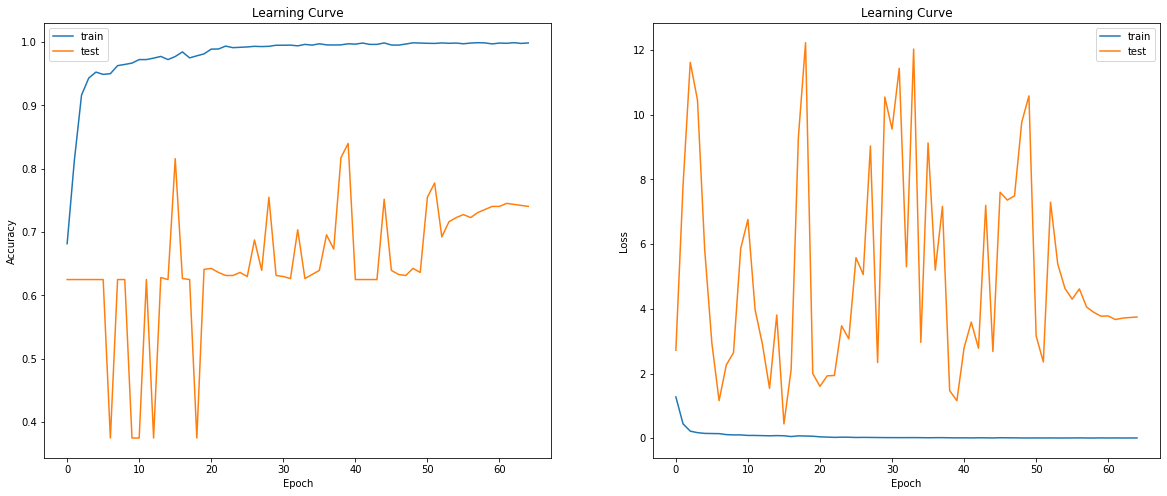

In [ ]:
draw_learning_curve(learning_history)

# CNN Model 1 Summary:

* Best accuracy this CNN model acheived was ~74%

* Simple sequential model was used, starting with 5 double convolutional networks of kernel size (3, 3) and max pooling with pool size (2, 2).
  Additionally has batch normalization and dropout



In [ ]:
# Visualizing our Confusion Matrices and Evaluating the Performance
from sklearn.metrics import confusion_matrix, classification_report

def visualize_training_results(results, model, X_test, y_test):
    y_hat_test = model.predict(X_test)
    thresh = 0.5
    y_pred = (y_hat_test > thresh).astype(np.int)
    y_true = y_test.astype(np.int)
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='0.5g')
    plt.xlabel('Predictions')
    plt.ylabel('Actuals')
    plt.title('Confusion Matrix')
    plt.show()
    print('\n')
    print('\n')

    print(classification_report(y_true, y_pred))
    print('\n')
    print('\n')
    
    print('Evaluating the Performance')
    print('\n')
    test_score = model.evaluate(X_test, y_test, verbose = 0)
    print(f'Test Loss: {test_score[0]}')
    print('\n')
    print(f'Test Accuracy: {test_score[1]}')

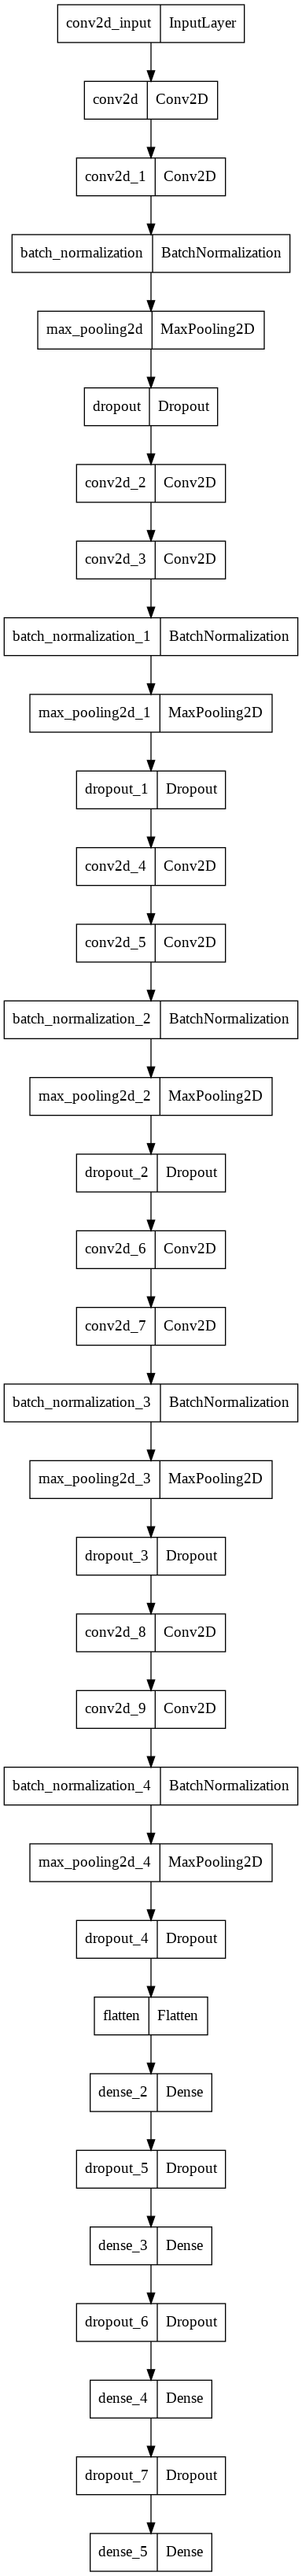

In [ ]:
plot_model(model, to_file='/content/drive/MyDrive/Phase_04_project/model_cnn_1.png')

In [ ]:
# Save 1st CNN model

save1_cnn = model.save('/content/drive/MyDrive/Phase_04_project/model_CNN_1.hdf5')

# Data augmentation
* Randomly shift images horizontally by 10% of the width

* Randomly shift images vertically by 10% of the height

* Randomly rotate images by 10 degrees

* Randomly Zoom by 10% some images

In [ ]:
# Lets see if accuracy can improve by manipulating the data

datagen = ImageDataGenerator(
        featurewise_center = False,
        samplewise_center = False,
        featurewise_std_normalization = False, 
        samplewise_std_normalization = False,
        zca_whitening = False,
        horizontal_flip = False,
        vertical_flip = False,
        rotation_range = 10,  
        zoom_range = 0.1, 
        width_shift_range = 0.1, 
        height_shift_range = 0.1)

datagen.fit(X_train)
train_gen = datagen.flow(X_train, y_train, batch_size = 32)

In [ ]:
callbacks4 = [ 
    EarlyStopping(monitor = 'loss', patience = 7), 
    ReduceLROnPlateau(monitor = 'loss', patience = 4), 
    ModelCheckpoint('/content/drive/MyDrive/Phase_04_project/model_CNN_2.hdf5', monitor='loss' , save_best_only=True) # saving the best model
]

# 2nd CNN model

In [ ]:
# Similar to first model, changing only weight in dropout and add layer

def get_modelcnn_v2():
    return Sequential([
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same', input_shape = input_shape),
        Conv2D(16, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2)),
        Dropout(0.2),
        
        Flatten(),
       
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        
        Dense(num_classes, activation = "softmax")
        
    ])

In [ ]:
model = get_modelcnn_v2()
model.compile(loss='categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      160       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 16)      2320      
                                                                 
 batch_normalization (BatchN  (None, 200, 200, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 100, 100, 16)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 32)      4

In [ ]:
# Fitting 2nd CNN model

#%%time 
#learning_history = model.fit_generator((train_gen), 
                               epochs = 100, 
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_test, y_test),
                               callbacks = callbacks4,
                        )





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/100
163/163 [==============================] - 740s 5s/step - loss: 0.5104 - accuracy: 0.7812 - val_loss: 2.6636 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/100
163/163 [==============================] - 740s 5s/step - loss: 0.2662 - accuracy: 0.9001 - val_loss: 3.0455 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/100
163/163 [==============================] - 734s 5s/step - loss: 0.2294 - accuracy: 0.9109 - val_loss: 6.2539 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/100
163/163 [==============================] - 734s 4s/step - loss: 0.2035 - accuracy: 0.9204 - val_loss: 5.3416 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/100
163/163 [==============================] - 738s 5s/step - loss: 0.1882 - accuracy: 0.9304 - val_loss: 28.8242 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/100
163/163 [==============================] - 740s 5s/step - loss: 0.1753 - accuracy: 0.9342 - val_loss: 4.2091 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/100
163/163 [==============================] - 73

In [25]:
%%time 
learning_history = model.fit_generator((train_gen), 
                               epochs = 40, 
                               steps_per_epoch = X_train.shape[0] // 32,
                               validation_data = (X_test, y_test),
                               callbacks = callbacks4,
                        )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """


Epoch 1/40
163/163 [==============================] - 816s 5s/step - loss: 0.5104 - accuracy: 0.7812 - val_loss: 2.6636 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 2/40
163/163 [==============================] - 820s 5s/step - loss: 0.2662 - accuracy: 0.9001 - val_loss: 3.0455 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 3/40
163/163 [==============================] - 816s 5s/step - loss: 0.2294 - accuracy: 0.9109 - val_loss: 6.2539 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 4/40
163/163 [==============================] - 813s 5s/step - loss: 0.2035 - accuracy: 0.9204 - val_loss: 5.3416 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 5/40
163/163 [==============================] - 857s 5s/step - loss: 0.1882 - accuracy: 0.9304 - val_loss: 28.8242 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/40
163/163 [==============================] - 825s 5s/step - loss: 0.1753 - accuracy: 0.9342 - val_loss: 4.2091 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 7/40
163/163 [==============================] - 819s 5s/s

In [26]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test loss: {}%'.format(score[0] * 100))
print('Test accuracy: {}%'.format(score[1] * 100))

print("MLP Error: %.2f%%" % (100 - score[1] * 100))

Test loss: 300.2533197402954%
Test accuracy: 62.66025900840759%
MLP Error: 37.34%


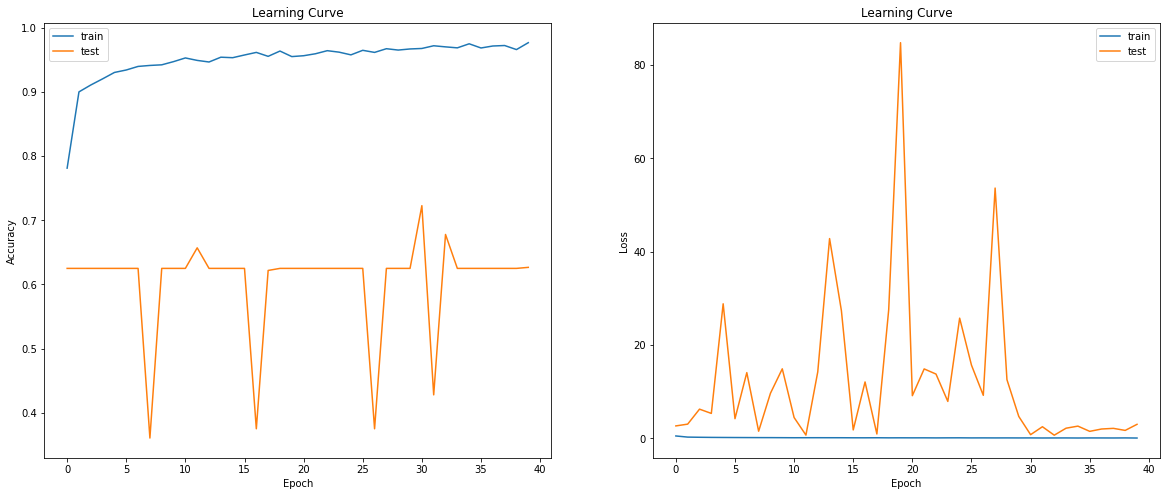

In [27]:
draw_learning_curve(learning_history)

# CNN Model 2 Summary:

* Best accuracy this MLP model acheived was ~%



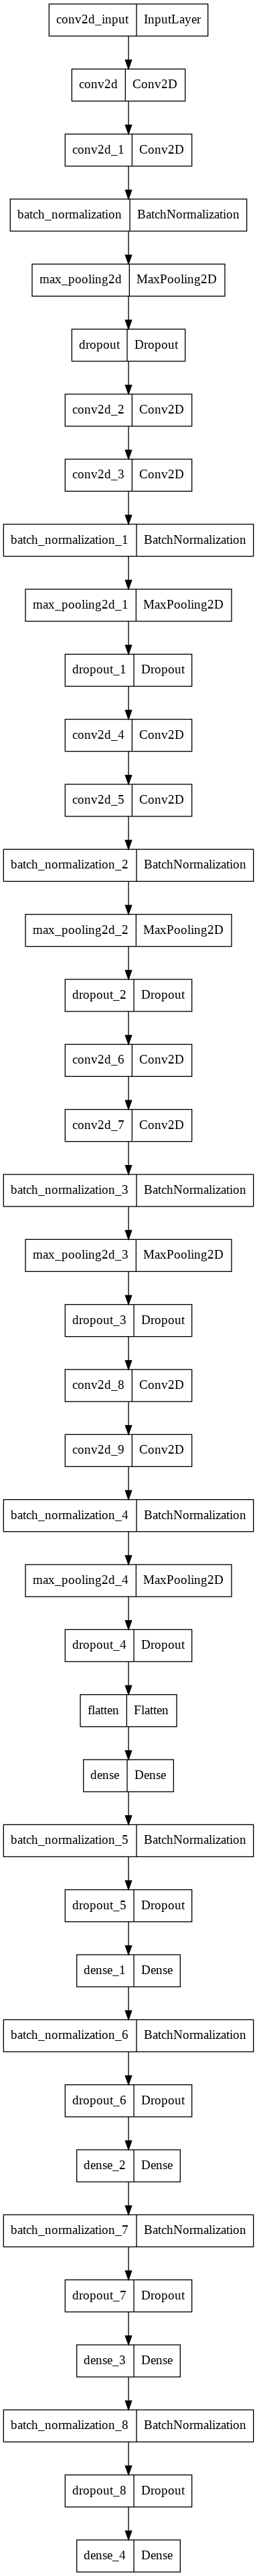

In [30]:
plot_model(model, to_file='/content/drive/MyDrive/Phase_04_project/model_cnn_2.png')

In [34]:
# Save 2nd CNN model

model.save('/content/drive/MyDrive/Phase_04_project/model_CNN_2.hdf5')